In [135]:
# Plotting libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import seaborn as sns## implement a maploptlib thing 
import matplotlib.pyplot as plt## a library to build plot 


from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

import re
import spacy
from spacy.language import Language

#import lasio
%matplotlib inline
plt.style.use('ggplot')

### Data Preprocessing  

In [2]:
Bcorp_data = pd.read_csv ('B Corp Impact Data.csv')

## count the number of de-certified SE
len(Bcorp_data[Bcorp_data["current_status"]== 'de-certified'])

2316

In [3]:
## filter columns needed
Bcorp_data_sele = Bcorp_data.filter(["company_id","company_name","date_first_certified","date_certified","current_status","description","industry","industry_category","products_and_services","country","state","size","assessment_year","overall_score","impact_area_community","impact_area_customers","impact_area_environment","impact_area_governance","impact_area_workers"])
## remove the de-certified SE
Bcorp_data_sele = Bcorp_data_sele[Bcorp_data_sele["current_status"] != "de-certified"]

In [4]:
## remove all the duplicated rows
norepeat_Bcorp_data_sele0 = Bcorp_data_sele.drop_duplicates(subset=['company_id'], keep=False)

In [5]:
## count the single SE in the list
norepeat_Bcorp_data_sele0.shape

(3433, 19)

In [6]:
## select the rows with duplicated company_id and create a new df 
duplicate = Bcorp_data_sele[Bcorp_data_sele.duplicated(['company_id'])]
## count the nnumber of duplicated SE
duplicate.shape

#duplicate.dtypes

(2904, 19)

In [7]:
## save the latest rate 
duplicate_clean = duplicate.sort_values(by='assessment_year', ascending=False).groupby("company_id").first()
## reset the index
duplicate_clean = duplicate_clean.reset_index(inplace=False)

In [8]:
## count the filtered rows 
duplicate_clean.shape

(1777, 19)

In [9]:
## compact the dfs and form a new df 
Bcorp_data_clean = pd.concat([norepeat_Bcorp_data_sele0, duplicate_clean])
## there are 5210 SEs in the project 
Bcorp_data_clean.shape

(5210, 19)

In [10]:
Bcorp_data_clean.head(4)

,company_id,company_name,date_first_certified,date_certified,current_status,description,industry,industry_category,products_and_services,country,state,size,assessment_year,overall_score,impact_area_community,impact_area_customers,impact_area_environment,impact_area_governance,impact_area_workers
0,001C000001UjCdkIAF,VEJA,2018-12-27,2018-12-27 00:00:00+00:00,certified,The VEJA project creates a positive chain. Sne...,Apparel,Wholesale,Fair trade sneakers made with organic cotton a...,France,Île-de-France,50-249,2018,84.2,23.9,NaN,26.5,11.4,22.1
1,001C000001ivBwkIAE,Olli Ella,2020-12-13,2020-12-13 22:35:54.396285+00:00,certified,Olli Ella creates timeless pieces that continu...,Other/general wholesale trade,Wholesale,"Consciously created homewares, toys and apparel",Australia,New South Wales,10-49,2019,104.7,38.9,3.3,28.5,13.7,19.9
12,0013b00001y8KL9AAM,Solution Nexam inc.,2022-04-08,2022-04-08 10:50:59.821134+00:00,certified,Solution Nexam est la première entreprise québ...,Software publishing and SaaS platforms,"Information, communication & technology",La Plateforme Nexam est spécialisée dans la ge...,Canada,Quebec,1-9,2021,85.8,20.4,19.3,5.0,15.0,25.9
13,0013b00001nDtF0AAK,Pathfinder,2020-08-24,2020-08-24 05:10:32.078123+00:00,certified,Pathfinder Asset Management is a fund manager ...,Investment advising,Financial & insurance activities,Financial Services,New Zealand,Auckland Region,1-9,2019,112.3,21.0,45.5,11.8,10.3,23.6


In [11]:
aa = Bcorp_data_clean[["overall_score","impact_area_community","impact_area_customers","impact_area_environment","impact_area_governance","impact_area_workers"]].describe()
#aa.to_csv('C:/Users/little page/Desktop/aa.csv') 

In [12]:
## fulfill NAN as 0 
Bcorp_data_clean = Bcorp_data_clean.fillna(0)
Bcorp_data_clean.head(4)
Bcorp_data_clean.columns

Index(['company_id', 'company_name', 'date_first_certified', 'date_certified',
       'current_status', 'description', 'industry', 'industry_category',
       'products_and_services', 'country', 'state', 'size', 'assessment_year',
       'overall_score', 'impact_area_community', 'impact_area_customers',
       'impact_area_environment', 'impact_area_governance',
       'impact_area_workers'],
      dtype='object')

In [13]:
Bcorp_data_clean = Bcorp_data_clean.rename(columns={"overall_score":"Overall Score"
                                        ,"impact_area_community":"Impact Area: Community"
                                       ,"impact_area_customers":"Impact Area: Customers"
                                       ,"impact_area_environment":"Impact Area: Environment" 
                                       ,"impact_area_governance":"Impact Area: Governance" 
                                       ,"impact_area_workers":"Impact Area: Workers" })

In [14]:
Bcorp_data_clean["industry_category"].unique()

array(['Wholesale', 'Information, communication & technology',
       'Financial & insurance activities', 'Waste Management & Recycling',
       'Human health & social work', 'Manufactured Goods', 'Retail',
       'Education', 'Administrative & support services',
       'Real estate, design & building',
       'Professional & technical services', 'Construction',
       'Other services', 'Agriculture, forestry & fishing',
       'Accommodation & food service', 'Arts, entertainment & recreation',
       'Energy', 'Transportation & storage', 'Rental & Repair',
       'Energy, Heating & Cooling', 'Publishing - Print',
       'Water & Sewerage'], dtype=object)

### Exploratory Data Analysis

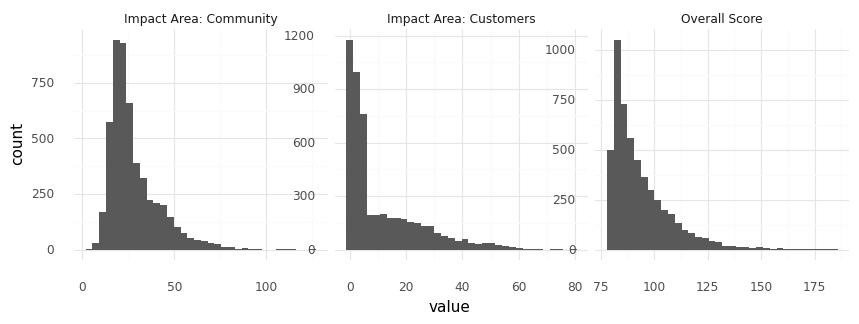

<ggplot: (113502312951)>

In [15]:
e = Bcorp_data_clean[["Impact Area: Community","Impact Area: Customers","Overall Score"]].melt()
(
    ggplot(e,aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
) 

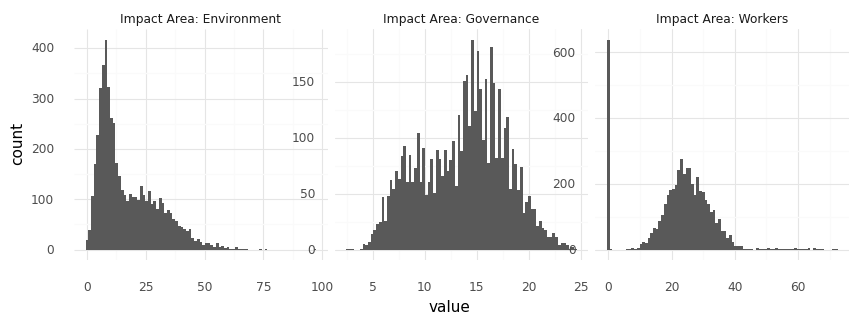

<ggplot: (113502708218)>

In [16]:
e = Bcorp_data_clean[["Impact Area: Environment","Impact Area: Governance","Impact Area: Workers"]].melt()
(
    ggplot(e,aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
) 


Spacy pipeline for text normalization & preprocessing

In [17]:

M = 2500

pipeline = spacy.load('en_core_web_sm')

# http://emailregex.com/
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

# replace = [ (pattern-to-replace, replacement),  ...]
replace = [
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (email_re, "email"),            # Matches emails
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "number"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "), # Punctuation and other junk
    (r"\s+", " ")                   # Stips extra whitespace
]

train_sentences = []
for i, d in enumerate(Bcorp_data_clean['description'][:M]):
    for repl in replace:
        d = re.sub(repl[0], repl[1], d)
    train_sentences.append(d)


@Language.component("lab04Preprocessor")
def ng20_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return " ".join(tokens)


pipeline.add_pipe("lab04Preprocessor")

<function __main__.ng20_preprocess(doc)>

In [18]:
docs = []
for sent in train_sentences[:M]:
    docs.append(pipeline(sent))
    
one_string = ' '.join(docs)

In [19]:
## Count words frequency 
l = one_string.split()
d = {}
for i in l:
    if i not in d.keys():
        d[i] = 0
    d[i] = d[i] +1

{'veja': 2, 'project': 333, 'create': 769, 'positive': 322, 'chain': 109, 'sneakers': 2, 'differently': 20, 'organic': 204, 'agroecological': 1, 'fairtrade': 19, 'cotton': 26, 'sneaker': 3, 'canvas': 3, 'wild': 36, 'rubber': 6, 'amazonian': 1, 'forest': 32, 'sol': 4, 'innovative': 200, 'material': 183, 'recycle': 79, 'plastic': 149, 'bottle': 47, 'new': 301, 'mesh': 2, 'minimalism': 2, 'innovation': 166, 'logistic': 22, 'shipping': 6, 'run': 69, 'ateliers': 3, 'sans': 8, 'frontières': 1, 'rehabilitation': 5, 'association': 32, 'brazil': 15, 'olli': 2, 'ella': 3, 'timeless': 19, 'piece': 31, 'continue': 65, 'love': 93, 'generation': 86, 'emphasis': 15, 'diversity': 60, 'social': 634, 'inclusion': 45, 'focus': 317, 'natural': 211, 'mindfully': 5, 'source': 168, 'true': 30, 'attention': 26, 'craftsmanship': 22, 'uplift': 6, 'community': 735, 'found': 259, 'number': 1882, 'sister': 13, 'chloe': 3, 'olivia': 1, 'brookman': 1, 'company': 1023, 'stretch': 6, 'globe': 28, 'office': 79, 'austra

In [20]:
df1 = pd.DataFrame([d.keys(), d.values()]).T
df1.columns = ['Word', 'Frequency']
df1 = df1.sort_values(by='Frequency', ascending=False).reset_index(drop= True)[:10]
df1

,Word,Frequency
0,number,1882
1,de,1774
2,business,1028
3,company,1023
4,people,838
5,product,817
6,work,815
7,impact,781
8,create,769
9,community,735


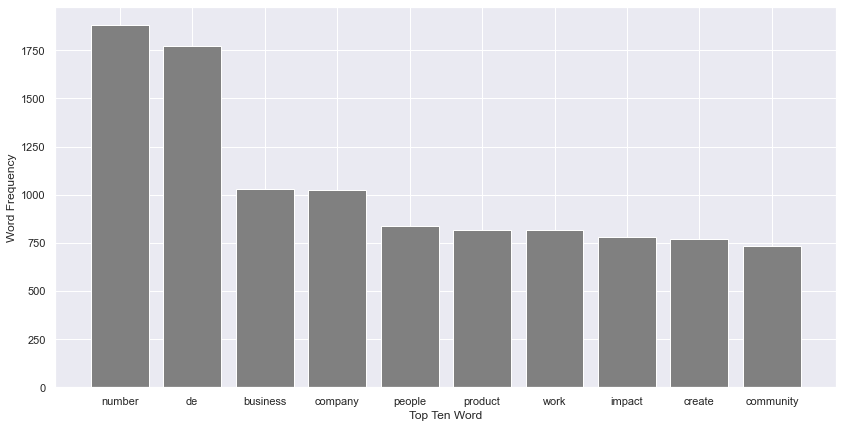

In [21]:
## visualize the words frequency 
x = df1["Word"].tolist()
y = df1["Frequency"].tolist()
x_pos = [i for i, _ in enumerate(x)]

plt.figure(figsize=(14, 7))
plt.bar(x_pos, y, color='gray')
plt.xlabel("Top Ten Word")
plt.ylabel("Word Frequency")
#plt.title("Figure 3  Most Common Words")
plt.xticks(x_pos, x)

plt.show()

#### Hopkins Statistic

Hopkins test for cluster tendency: The idea is the closer the value to 1, the higher the likelihood of clusters.

In [136]:
data_q2 = Bcorp_data_clean[['Impact Area: Community', 'Impact Area: Customers'
                            , 'Impact Area: Environment','Impact Area: Governance'
                           ,"Impact Area: Workers"]]

In [139]:
def hopkins(X):
    """
    input X: df
    return: Hopkins statistic score
    """ 
    d = X.shape[1]
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0

    return H

In [140]:
hopkins(data_q2)

0.9209346144137834

###  K-means Clustering  

Test the value of K 

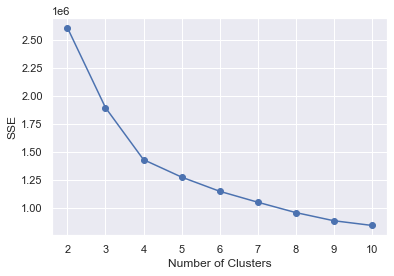

In [149]:
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_q2)
    Bcorp_data_clean["company_id"] = kmeans.labels_
    # Inertia: Sum of distances of samples to their closest cluster center
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()),marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [24]:
silhouette_avg = [silhouette_score(data_q2, KMeans(n_clusters = i, random_state = 10).fit_predict(data_q2)) for i in range(2,11)]

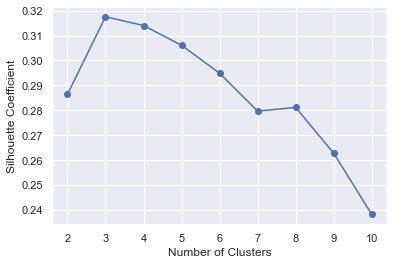

In [25]:
plt.plot(range(2,11),silhouette_avg ,marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Dividing the data into three clusters can better reflect the similarity of data within clusters and the degree of difference between clusters,

In [26]:
km = KMeans(n_clusters = 3)
y_predicted = km.fit_predict(Bcorp_data_clean[['Impact Area: Community', 'Impact Area: Customers'
                            , 'Impact Area: Environment','Impact Area: Governance'
                           ,"Impact Area: Workers"]])

In [27]:
Bcorp_data_clean["cluster"] = y_predicted

In [28]:
Bcorp_data_clean.shape

(5210, 20)

In [29]:
Bcorp_data_0 = Bcorp_data_clean[Bcorp_data_clean['cluster'] == 0]
Bcorp_data_1 = Bcorp_data_clean[Bcorp_data_clean['cluster'] == 1]
Bcorp_data_2 = Bcorp_data_clean[Bcorp_data_clean['cluster'] == 2]

In [30]:
Bcorp_data_0.shape

(931, 20)

In [31]:
Bcorp_data_1.shape

(2376, 20)

In [32]:
Bcorp_data_2.shape

(1903, 20)

In [33]:
Bcorp_data_0_col = Bcorp_data_0[['Impact Area: Community', 'Impact Area: Customers'
                            , 'Impact Area: Environment','Impact Area: Governance'
                           ,"Impact Area: Workers"]]
Bcorp_data_1_col = Bcorp_data_1[['Impact Area: Community', 'Impact Area: Customers'
                            , 'Impact Area: Environment','Impact Area: Governance'
                           ,"Impact Area: Workers"]]
Bcorp_data_2_col = Bcorp_data_2[['Impact Area: Community', 'Impact Area: Customers'
                            , 'Impact Area: Environment','Impact Area: Governance'
                           ,"Impact Area: Workers"]]

In [34]:
Bcorp_data_0_col.describe()

,Impact Area: Community,Impact Area: Customers,Impact Area: Environment,Impact Area: Governance,Impact Area: Workers
count,931.000000,931.000000,931.000000,931.000000,931.000000
mean,51.236305,10.732438,14.412675,13.194737,9.672288
std,13.115162,13.753816,9.027490,4.303552,10.751280
min,27.700000,0.000000,0.000000,3.000000,0.000000
25%,42.300000,0.000000,7.800000,9.700000,0.000000
50%,48.000000,3.800000,12.000000,13.500000,0.000000
75%,57.300000,18.450000,18.750000,16.550000,19.900000
max,125.400000,68.200000,55.000000,23.300000,38.200000


In [35]:
Bcorp_data_1_col.describe()

,Impact Area: Community,Impact Area: Customers,Impact Area: Environment,Impact Area: Governance,Impact Area: Workers
count,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000
mean,22.954082,18.908838,8.352946,14.567003,28.054714
std,7.031770,14.777579,3.945158,4.038248,9.148473
min,3.800000,0.000000,0.000000,4.200000,0.000000
25%,17.900000,6.000000,5.700000,11.600000,23.900000
50%,22.300000,16.100000,7.900000,15.100000,28.500000
75%,27.000000,27.300000,10.500000,17.500000,32.800000
max,60.400000,79.400000,35.500000,24.500000,72.100000


In [36]:
Bcorp_data_2_col.describe()

,Impact Area: Community,Impact Area: Customers,Impact Area: Environment,Impact Area: Governance,Impact Area: Workers
count,1903.000000,1903.000000,1903.000000,1903.000000,1903.000000
mean,22.995166,2.424698,30.618445,13.011613,22.167578
std,7.653413,2.954730,10.252632,3.818042,7.023130
min,6.500000,0.000000,12.200000,2.600000,0.000000
25%,17.500000,0.000000,22.900000,9.800000,19.100000
50%,21.300000,2.300000,29.200000,13.800000,22.700000
75%,27.100000,3.700000,36.700000,15.800000,25.900000
max,58.200000,34.500000,96.900000,23.700000,65.600000


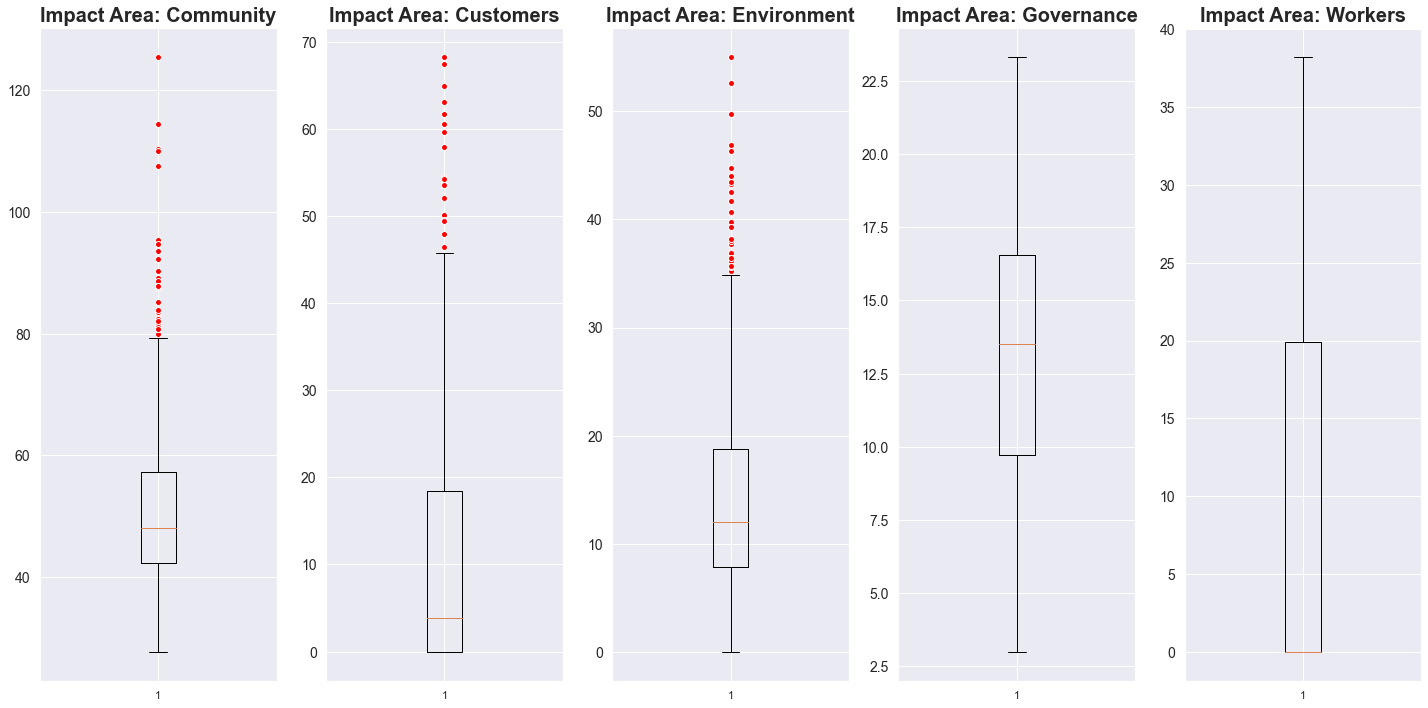

In [37]:
#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(Bcorp_data_0_col.columns), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(Bcorp_data_0_col.iloc[:,i], flierprops=red_circle)
    ax.set_title(Bcorp_data_0_col.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)    
plt.tight_layout()

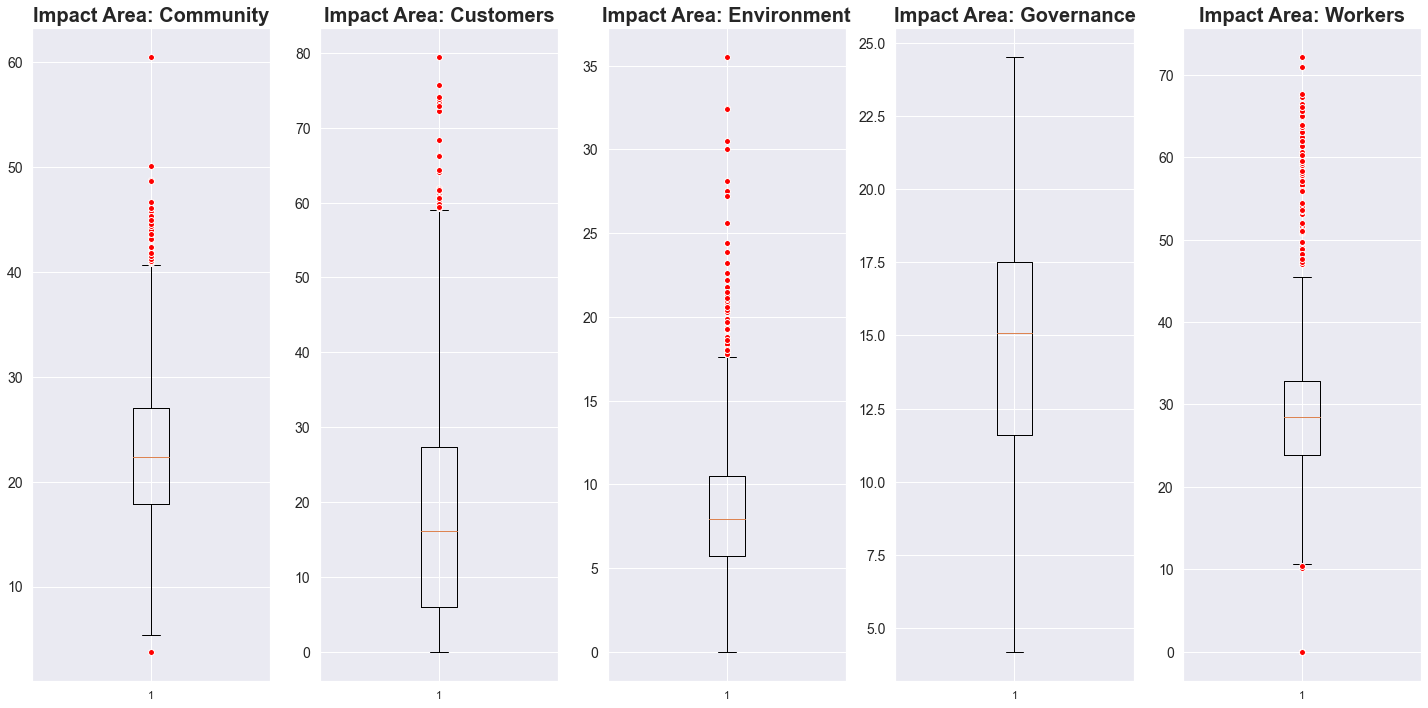

In [38]:
#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(Bcorp_data_1_col.columns), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(Bcorp_data_1_col.iloc[:,i], flierprops=red_circle)
    ax.set_title(Bcorp_data_1_col.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)    
plt.tight_layout()

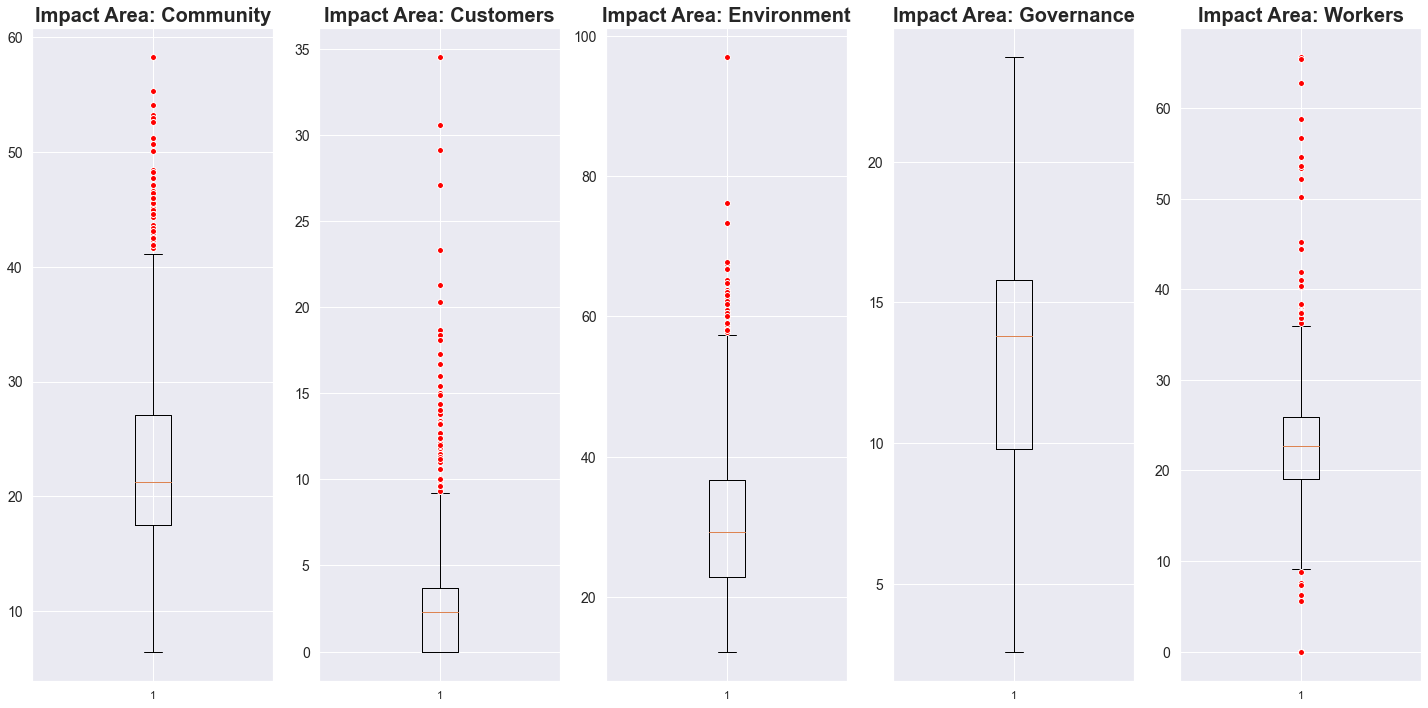

In [39]:
#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(Bcorp_data_2_col.columns), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(Bcorp_data_2_col.iloc[:,i], flierprops=red_circle)
    ax.set_title(Bcorp_data_2_col.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)    
plt.tight_layout()

In [171]:
Bcorp_data_0.head()

,company_id,company_name,date_first_certified,date_certified,current_status,description,industry,industry_category,products_and_services,country,state,size,assessment_year,Overall Score,Impact Area: Community,Impact Area: Customers,Impact Area: Environment,Impact Area: Governance,Impact Area: Workers,cluster
25,5,Jack and Ferdi,2022-03-30,2022-03-30 15:42:49.662606+00:00,certified,Jack and Ferdi PBC's social mission is to help...,Technology-based support services,Human health & social work,0,United States,Massachusetts,0,2020,90.6,62.1,2.0,8.9,17.5,0.0,0
50,0,"Saalt, LLC",2019-06-14,2019-06-14 00:00:00+00:00,certified,Saalt empowers people to care for their period...,Personal care products,Retail,Sustainable and reusable period care,United States,Idaho,10-49,2018,93.3,38.5,6.7,17.9,11.5,18.5,0
73,3,Bemari Ltd,2020-06-02,2020-06-02 09:57:36.901977+00:00,certified,Bemari offers sustainability and procurement c...,Management consultant - for-profits,Professional & technical services,"Sustainability & carbon strategy, sustainable ...",United Kingdom,Hertfordshire,0,2019,92.7,37.4,28.6,11.4,15.2,0.0,0
92,9,Tiny Miracles,2020-07-16,2020-07-16 08:39:08.808239+00:00,certified,Tiny Miracles stems from a deep-rooted belief ...,Paper & paper products,Wholesale,Interior design products,Netherlands The,Noord Holland,1-9,2019,81.6,47.4,2.0,9.2,15.2,7.5,0
93,9,Expert Advice / Sleeping Lion,2022-04-11,2022-04-11 12:04:39.256763+00:00,certified,Expert Advice / Sleeping Lion have a suite of ...,Management consultant - for-profits,Professional & technical services,0,United Kingdom,City of Westminster,0,2021,94.3,58.5,11.2,8.1,16.3,0.0,0


In [175]:
Bcorp_data_0["industry_category"].unique()

array(['Human health & social work', 'Retail',
       'Professional & technical services', 'Wholesale',
       'Financial & insurance activities', 'Manufactured Goods',
       'Other services', 'Information, communication & technology',
       'Agriculture, forestry & fishing',
       'Arts, entertainment & recreation', 'Accommodation & food service',
       'Education', 'Administrative & support services',
       'Waste Management & Recycling', 'Real estate, design & building',
       'Transportation & storage', 'Energy', 'Publishing - Print',
       'Construction', 'Energy, Heating & Cooling'], dtype=object)

In [208]:
industry = Bcorp_data_0["industry_category"].value_counts()
industry_0 = pd.DataFrame(industry)
industry_0.reset_index(drop=False, inplace=True)
#industry_0 .to_csv('industry_0.csv')
industry_0

,index,industry_category
0,Professional & technical services,251
1,Retail,202
2,Manufactured Goods,106
3,Wholesale,92
4,"Information, communication & technology",51
5,"Agriculture, forestry & fishing",38
6,Financial & insurance activities,36
7,"Arts, entertainment & recreation",29
8,Other services,26
9,Administrative & support services,24


In [207]:
industry = Bcorp_data_1["industry_category"].value_counts()
industry_1 = pd.DataFrame(industry)
industry_1.reset_index(drop=False, inplace=True)
#industry_1.to_csv('industry_1.csv')
industry_1

,index,industry_category
0,Professional & technical services,879
1,"Information, communication & technology",414
2,Financial & insurance activities,405
3,Education,118
4,Other services,105
5,Administrative & support services,94
6,Human health & social work,77
7,"Arts, entertainment & recreation",75
8,Manufactured Goods,53
9,Retail,47


In [206]:
industry = Bcorp_data_2["industry_category"].value_counts()
industry_2 = pd.DataFrame(industry)
industry_2.reset_index(drop=False, inplace=True)
#industry_2.to_csv('industry_2.csv')
industry_2

,index,industry_category
0,Manufactured Goods,449
1,Retail,385
2,Wholesale,304
3,"Agriculture, forestry & fishing",137
4,"Real estate, design & building",127
5,Professional & technical services,126
6,Energy,92
7,"Information, communication & technology",61
8,Other services,52
9,Accommodation & food service,37


In [205]:
country = Bcorp_data_0["country"].value_counts()
country_0 = pd.DataFrame(country)
country_0.reset_index(drop=False, inplace=True)
#country_0.to_csv('country_0.csv')
country_0

,index,country
0,United States,377
1,United Kingdom,107
2,Australia,88
3,Canada,69
4,Argentina,34
5,Netherlands The,29
6,Brazil,28
7,Chile,27
8,Italy,16
9,France,14


In [204]:
country = Bcorp_data_1["country"].value_counts()
country_1 = pd.DataFrame(country)
country_1.reset_index(drop=False, inplace=True)
#country_1.to_csv('country_1.csv')
country_1

,index,country
0,United States,650
1,United Kingdom,491
2,Canada,179
3,Australia,168
4,France,101
5,Brazil,99
6,Netherlands The,76
7,Italy,74
8,Argentina,60
9,Chile,60


In [203]:
country = Bcorp_data_2["country"].value_counts()
country_2 = pd.DataFrame(country)
country_2.reset_index(drop=False, inplace=True)
#country_2.to_csv('country_2.csv')
country_2

,index,country
0,United States,531
1,United Kingdom,282
2,Canada,127
3,Australia,122
4,France,94
5,Brazil,89
6,Italy,86
7,Argentina,66
8,Chile,62
9,Netherlands The,50


### Validation 

In [ ]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

In [94]:
## Standardize the Data
# define standard scaler
scaler = StandardScaler()

# transform data
pset1_data_st = pd.DataFrame.from_records(scaler.fit_transform(data_q2),columns = data_q2.columns)

# display the first five rows
pset1_data_st.head()

,Impact Area: Community,Impact Area: Customers,Impact Area: Environment,Impact Area: Governance,Impact Area: Workers
0,-0.297651,-0.825263,0.700150,-0.577334,-0.047369
1,0.785248,-0.586931,0.856932,-0.013164,-0.247955
2,-0.550328,0.568619,-0.985252,0.305715,0.299098
3,-0.507012,2.460831,-0.452195,-0.847154,0.089394
4,-0.781346,-0.825263,1.977920,-0.503747,-1.059417


In [104]:
# use the PCA() function from the sklearn package perform principal components analysis.
#define PCA model to use
pca=PCA()
#fit PCA model to data
pca.fit(pset1_data_st)
# calculate the loadings of principal components(pca.components_)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4','PC5'], index=['Community','Customers','Environment', 'Governance',"Workers"])
loadings

,PC1,PC2,PC3,PC4,PC5
Community,0.434940,0.513819,-0.288971,0.493718,0.468567
Customers,-0.428151,0.518750,0.354097,-0.423298,0.492970
Environment,0.535682,-0.463103,0.032050,-0.470203,0.525797
Governance,-0.314066,0.001331,-0.888046,-0.324892,0.084731
Workers,-0.491856,-0.502416,0.038186,0.500414,0.503769


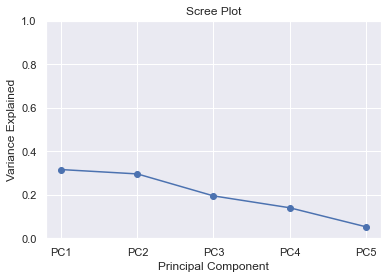

In [103]:
## Create a scree plot based on the PCA results.
# plot the PVE
PC_values = np.arange(pca.n_components_) 
plt.plot(PC_values, pca.explained_variance_ratio_,marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.ylim(0,1)
plt.xticks(np.arange(5),('PC1','PC2','PC3','PC4',"PC5"))
plt.show()

Pick PC1 and PC2

In [109]:
pset1_data_st["PC1"]=pset1_data_st["Impact Area: Community"]*(0.434940) + pset1_data_st["Impact Area: Customers"]*(-0.428151)+pset1_data_st["Impact Area: Environment"]*(0.535682)+pset1_data_st["Impact Area: Governance"]*(-0.314066)+pset1_data_st["Impact Area: Workers"]*(-0.491856)
pset1_data_st["PC2"]=pset1_data_st["Impact Area: Community"]*(0.513819) + pset1_data_st["Impact Area: Customers"]*(0.518750)+pset1_data_st["Impact Area: Environment"]*(-0.463103)+pset1_data_st["Impact Area: Governance"]*(0.001331)+pset1_data_st["Impact Area: Workers"]*(-0.502416)

In [110]:
pset1_data_st.head(2)

,Impact Area: Community,Impact Area: Customers,Impact Area: Environment,Impact Area: Governance,Impact Area: Workers,PC1,PC2
0,-0.297651,-0.825263,0.700150,-0.577334,-0.047369,0.803554,-0.882255
1,0.785248,-0.586931,0.856932,-0.013164,-0.247955,1.177966,-0.173283


In [111]:
data_q2_0 = pset1_data_st[['PC1',"PC2"]]

In [131]:
data_q2_0.describe()

,PC1,PC2
count,5.210000e+03,5.210000e+03
mean,-2.118374e-16,2.301422e-18
std,1.256837e+00,1.216391e+00
min,-4.120455e+00,-3.815943e+00
25%,-9.876365e-01,-8.754404e-01
50%,-7.955921e-02,-1.973208e-01
75%,9.119889e-01,6.313089e-01
max,4.245279e+00,4.672784e+00


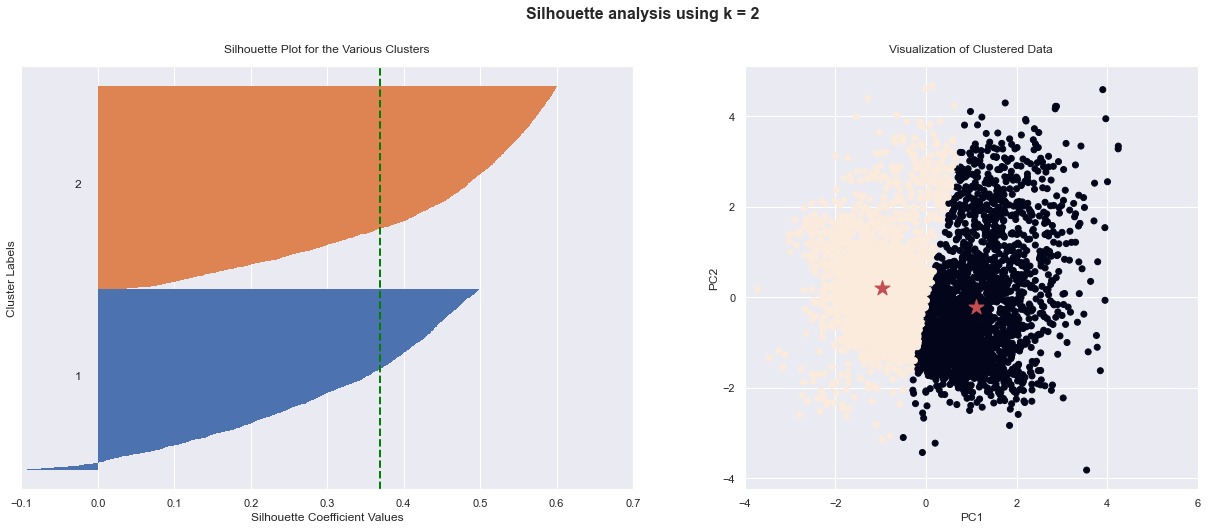

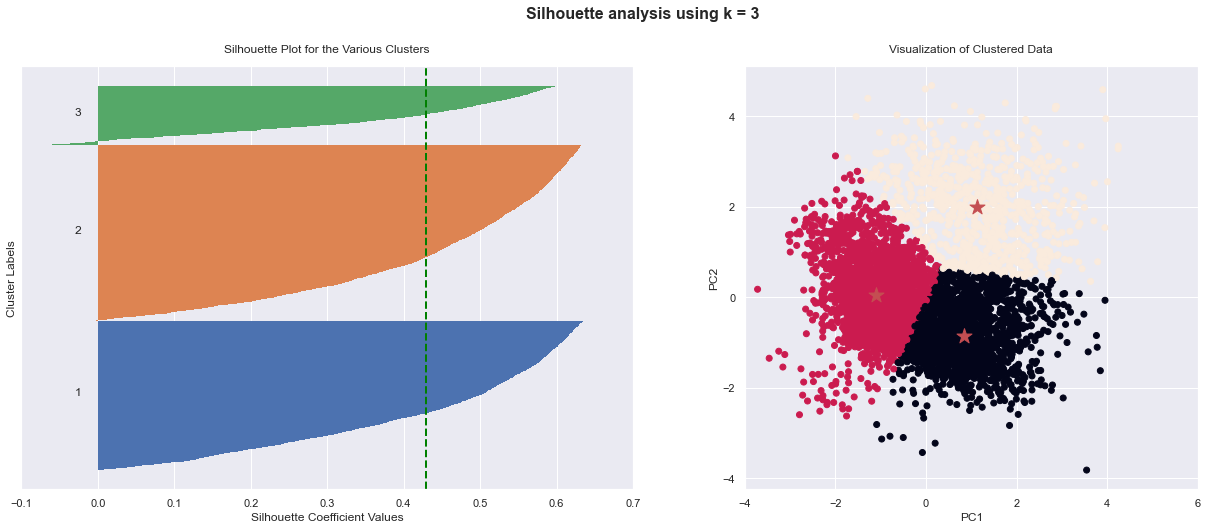

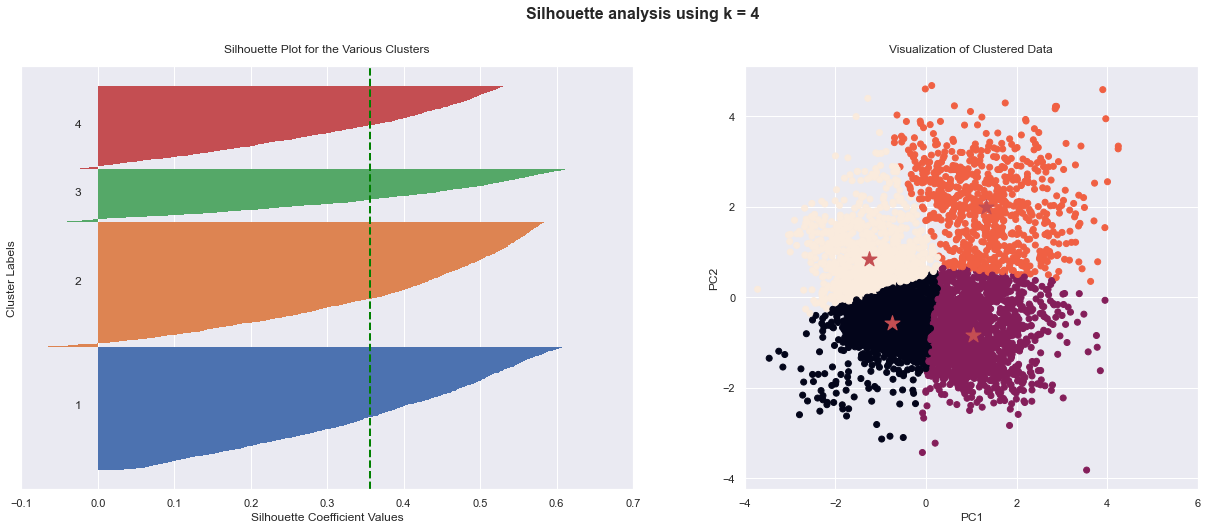

In [134]:
for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(data_q2_0)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(data_q2_0, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 0.7])
    ax1.set_xlabel('Silhouette Coefficient Values')
    ax1.set_ylabel('Cluster Labels')
    ax1.set_title('Silhouette Plot for the Various Clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(data_q2_0.iloc[:,0].values, data_q2_0.iloc[:,1].values, c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-4, 4])
    ax2.set_xlim([-4, 6])
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_title('Visualization of Clustered Data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

#### WordCloud 

In [40]:
# For regular expressions
import re
# For handling string
import string
# For performing mathematical operations
import math
# For removal of stopwords and lemmatization
import spacy
# For creating a Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

In [41]:
Bcorp_data_0.head(2)

,company_id,company_name,date_first_certified,date_certified,current_status,description,industry,industry_category,products_and_services,country,state,size,assessment_year,Overall Score,Impact Area: Community,Impact Area: Customers,Impact Area: Environment,Impact Area: Governance,Impact Area: Workers,cluster
25,5,Jack and Ferdi,2022-03-30,2022-03-30 15:42:49.662606+00:00,certified,Jack and Ferdi PBC's social mission is to help...,Technology-based support services,Human health & social work,0,United States,Massachusetts,0,2020,90.6,62.1,2.0,8.9,17.5,0.0,0
50,0,"Saalt, LLC",2019-06-14,2019-06-14 00:00:00+00:00,certified,Saalt empowers people to care for their period...,Personal care products,Retail,Sustainable and reusable period care,United States,Idaho,10-49,2018,93.3,38.5,6.7,17.9,11.5,18.5,0


In [42]:
traindata_0 = Bcorp_data_0.filter(["description"])
traindata_1 = Bcorp_data_1.filter(["description"])
traindata_2 = Bcorp_data_2.filter(["description"])

Expand Contractions

In [43]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

In [44]:
traindata_0['description']= traindata_0['description'].astype(str)
traindata_1['description']= traindata_1['description'].astype(str)
traindata_2['description']= traindata_2['description'].astype(str)

In [45]:
# Expanding Contractions in the reviews
traindata_0['description']=traindata_0['description'].apply(lambda x:expand_contractions(x))
traindata_1['description']=traindata_1['description'].apply(lambda x:expand_contractions(x))
traindata_2['description']=traindata_2['description'].apply(lambda x:expand_contractions(x))

Lowercase the texts

In [46]:
traindata_0['description']=traindata_0['description'].apply(lambda x: x.lower())
traindata_1['description']=traindata_1['description'].apply(lambda x: x.lower())
traindata_2['description']=traindata_2['description'].apply(lambda x: x.lower())

Remove digits and words containing digits

In [47]:
traindata_0['description']=traindata_0['description'].apply(lambda x: re.sub('\w*\d\w*','', x))
traindata_1['description']=traindata_1['description'].apply(lambda x: re.sub('\w*\d\w*','', x))
traindata_2['description']=traindata_2['description'].apply(lambda x: re.sub('\w*\d\w*','', x))

Remove Punctuations

In [48]:
traindata_0['description']=traindata_0['description'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
traindata_1['description']=traindata_1['description'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
traindata_2['description']=traindata_2['description'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [49]:
# Removing extra spaces
traindata_0['description']=traindata_0['description'].apply(lambda x: re.sub(' +',' ',x))
traindata_1['description']=traindata_1['description'].apply(lambda x: re.sub(' +',' ',x))
traindata_2['description']=traindata_2['description'].apply(lambda x: re.sub(' +',' ',x))

Preparing Text Data for Exploratory Data Analysis (EDA)

In [50]:
# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
traindata_0['description_lemmatized']=traindata_0['description'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
traindata_1['description_lemmatized']=traindata_1['description'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
traindata_2['description_lemmatized']=traindata_2['description'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [51]:
list0_Text_lemmatized = traindata_0['description_lemmatized'].to_list()
list1_Text_lemmatized = traindata_1['description_lemmatized'].to_list()
list2_Text_lemmatized = traindata_2['description_lemmatized'].to_list()

In [52]:
Text0_lemmatized_onestring = ' '.join(list0_Text_lemmatized)
Text1_lemmatized_onestring = ' '.join(list1_Text_lemmatized)
Text2_lemmatized_onestring = ' '.join(list2_Text_lemmatized)

In [53]:
# Create and Generate a Word Cloud Image
wordcloud = WordCloud(width=700, 
                      height=700,
                      prefer_horizontal=0.5,
                      background_color="white", 
                      mode="RGBA")
#wordcloud = WordCloud(width=800,height=400,colormap="Dark2")

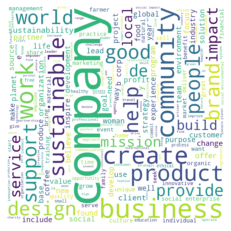

In [54]:
wordcloud_text0 = wordcloud.generate(Text0_lemmatized_onestring)
#Display the generated image
plt.imshow(wordcloud_text0, interpolation="bilinear")
plt.axis('off')
plt.show()
# save
#wordcloud_text0.to_file("text0_wc.png")

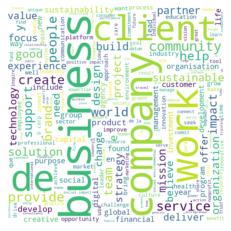

In [55]:
wordcloud_text1 = wordcloud.generate(Text1_lemmatized_onestring)
#Display the generated image
plt.imshow(wordcloud_text1, interpolation="bilinear")
plt.axis('off')
plt.show()
# save
#wordcloud_text1.to_file("text1_wc.png")

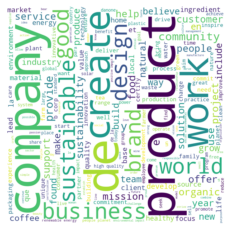

In [56]:
wordcloud_text2 = wordcloud.generate(Text2_lemmatized_onestring)
#Display the generated image
plt.imshow(wordcloud_text2, interpolation="bilinear")
plt.axis('off')
plt.show()
# save
#wordcloud_text2.to_file("text2_wc.png")

#### Bag of Words

In [151]:
M = 2500

pipeline = spacy.load('en_core_web_sm')

# http://emailregex.com/
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

# replace = [ (pattern-to-replace, replacement),  ...]
replace = [
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (email_re, "email"),            # Matches emails
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "number"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "), # Punctuation and other junk
    (r"\s+", " ")                   # Stips extra whitespace
]

train_sentences = []
for i, d in enumerate(Bcorp_data_0['description'][:M]):
    for repl in replace:
        d = re.sub(repl[0], repl[1], str(d))
    train_sentences.append(d)


@Language.component("lab04Preprocessor")
def ng20_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return " ".join(tokens)


pipeline.add_pipe("lab04Preprocessor")

<function __main__.ng20_preprocess(doc)>

In [152]:
docs_0 = []
for sent in train_sentences[:M]:
    docs_0.append(pipeline(sent))
    
one_string = ' '.join(docs_0)

In [153]:
## Count words frequency 
l = one_string.split()
d = {}
for i in l:
    if i not in d.keys():
        d[i] = 0
    d[i] = d[i] +1

In [154]:
df1 = pd.DataFrame([d.keys(), d.values()]).T
df1.columns = ['Word', 'Frequency']
df1 = df1.sort_values(by='Frequency', ascending=False).reset_index(drop= True)[:14]
df1

,Word,Frequency
0,number,606
1,business,551
2,company,427
3,community,386
4,social,379
5,create,361
6,work,345
7,impact,343
8,people,316
9,help,310


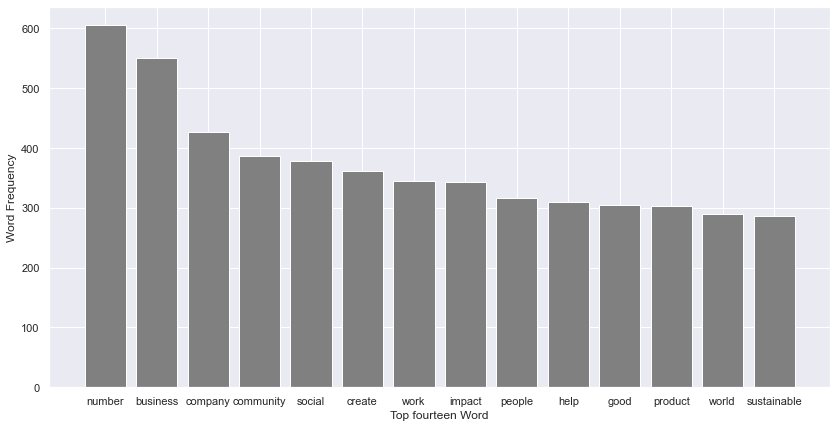

In [155]:
## visualize the words frequency 
x = df1["Word"].tolist()
y = df1["Frequency"].tolist()
x_pos = [i for i, _ in enumerate(x)]

plt.figure(figsize=(14, 7))
fig = plt.bar(x_pos, y, color='gray')
plt.xlabel("Top fourteen Word")
plt.ylabel("Word Frequency")
#plt.title("Figure 3  Most Common Words")
plt.xticks(x_pos, x)

plt.show()

In [156]:
M = 2500

pipeline = spacy.load('en_core_web_sm')

# http://emailregex.com/
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

# replace = [ (pattern-to-replace, replacement),  ...]
replace = [
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (email_re, "email"),            # Matches emails
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "number"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "), # Punctuation and other junk
    (r"\s+", " ")                   # Stips extra whitespace
]

train_sentences = []
for i, d in enumerate(Bcorp_data_1['description'][:M]):
    for repl in replace:
        d = re.sub(repl[0], repl[1], str(d))
    train_sentences.append(d)


@Language.component("lab04Preprocessor")
def ng20_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return " ".join(tokens)


pipeline.add_pipe("lab04Preprocessor")

<function __main__.ng20_preprocess(doc)>

In [157]:
docs_1 = []
for sent in train_sentences[:M]:
    docs_1.append(pipeline(sent))
    
one_string = ' '.join(docs_1)

In [158]:
## Count words frequency 
l = one_string.split()
d = {}
for i in l:
    if i not in d.keys():
        d[i] = 0
    d[i] = d[i] +1

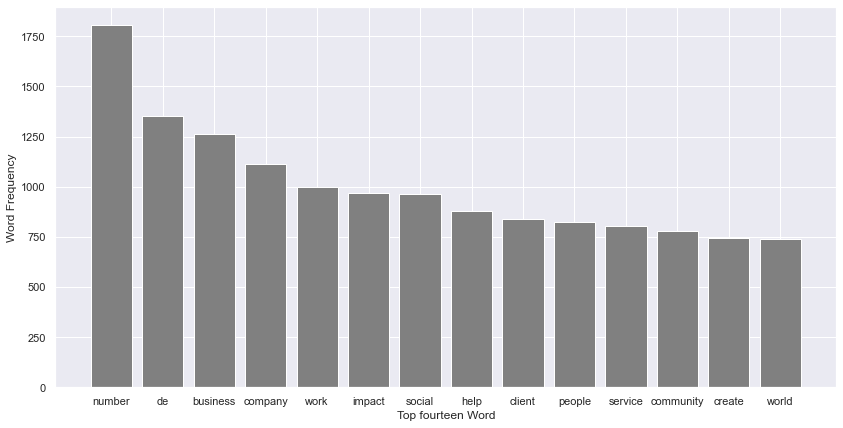

In [159]:
df1 = pd.DataFrame([d.keys(), d.values()]).T
df1.columns = ['Word', 'Frequency']
df1 = df1.sort_values(by='Frequency', ascending=False).reset_index(drop= True)[:14]
df1

## visualize the words frequency 

x = df1["Word"].tolist()
y = df1["Frequency"].tolist()
x_pos = [i for i, _ in enumerate(x)]

plt.figure(figsize=(14, 7))
plt.bar(x_pos, y, color='gray')
plt.xlabel("Top fourteen Word")
plt.ylabel("Word Frequency")
#plt.title("Figure 3  Most Common Words")
plt.xticks(x_pos, x)

plt.show()

In [160]:
M = 2500

pipeline = spacy.load('en_core_web_sm')

# http://emailregex.com/
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

# replace = [ (pattern-to-replace, replacement),  ...]
replace = [
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (email_re, "email"),            # Matches emails
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "number"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "), # Punctuation and other junk
    (r"\s+", " ")                   # Stips extra whitespace
]

train_sentences = []
for i, d in enumerate(Bcorp_data_2['description'][:M]):
    for repl in replace:
        d = re.sub(repl[0], repl[1], str(d))
    train_sentences.append(d)


@Language.component("lab04Preprocessor")
def ng20_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return " ".join(tokens)


pipeline.add_pipe("lab04Preprocessor")

<function __main__.ng20_preprocess(doc)>

In [161]:
docs_2 = []
for sent in train_sentences[:M]:
    docs_2.append(pipeline(sent))
    
one_string = ' '.join(docs_2)

In [162]:
## Count words frequency 
l = one_string.split()
d = {}
for i in l:
    if i not in d.keys():
        d[i] = 0
    d[i] = d[i] +1

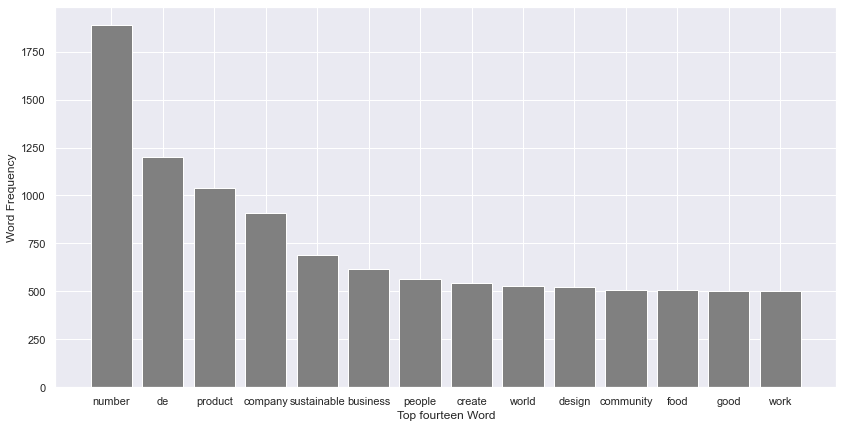

In [163]:
df1 = pd.DataFrame([d.keys(), d.values()]).T
df1.columns = ['Word', 'Frequency']
df1 = df1.sort_values(by='Frequency', ascending=False).reset_index(drop= True)[:14]
df1

## visualize the words frequency 

x = df1["Word"].tolist()
y = df1["Frequency"].tolist()
x_pos = [i for i, _ in enumerate(x)]

plt.figure(figsize=(14, 7))
plt.bar(x_pos, y, color='gray')
plt.xlabel("Top fourteen Word")
plt.ylabel("Word Frequency")
#plt.title("Figure 3  Most Common Words")
plt.xticks(x_pos, x)

plt.show()

#### TF-IDF

In [70]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer
import random

vectorizer = TfidfVectorizer() 

In [77]:
print(len(list0_Text_lemmatized))
print(len(list1_Text_lemmatized))
print(len(list2_Text_lemmatized))

931
2376
1903


In [167]:
# fit the model list0_Text_lemmatized
vectors_0 = vectorizer.fit_transform(list0_Text_lemmatized)

# Select all documents from the data set
tf_idf = pd.DataFrame(vectors_0.todense()).iloc[:931]  
tf_idf.columns = vectorizer.get_feature_names()
tfidf_matrix = tf_idf.T
tfidf_matrix.columns = ['description'+ str(i) for i in range(1, 932)]
tfidf_matrix['count'] = tfidf_matrix.sum(axis=1)

# Top 10 words 
tfidf_matrix = tfidf_matrix.sort_values(by ='count', ascending=False)[:21]
#tfidf_matrix = tfidf_matrix.iloc[1:]

## only present the first 7 columns 
tfidf_matrix_0  = tfidf_matrix.drop(columns=['count']).iloc[: , :7]
#tfidf_matrix_0.to_csv('tfidf_matrix_0.csv')
tfidf_matrix_0

,description1,description2,description3,description4,description5,description6,description7
business,0.077525,0.000000,0.070968,0.034098,0.209665,0.000000,0.000000
company,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
social,0.056518,0.000000,0.000000,0.037288,0.000000,0.087829,0.000000
impact,0.029324,0.000000,0.080533,0.000000,0.000000,0.000000,0.000000
product,0.000000,0.000000,0.000000,0.082531,0.042290,0.097199,0.000000
community,0.027829,0.000000,0.000000,0.073441,0.000000,0.000000,0.000000
people,0.000000,0.192164,0.000000,0.038976,0.000000,0.000000,0.000000
create,0.027643,0.000000,0.000000,0.036475,0.000000,0.000000,0.000000
help,0.029756,0.000000,0.081718,0.078526,0.000000,0.000000,0.000000
work,0.028604,0.000000,0.000000,0.000000,0.038679,0.000000,0.000000


In [165]:
# fit the model 
vectors_1 = vectorizer.fit_transform(list1_Text_lemmatized)

# Select all documents from the data set
tf_idf = pd.DataFrame(vectors_1.todense()).iloc[:2376]  
tf_idf.columns = vectorizer.get_feature_names()
tfidf_matrix = tf_idf.T
tfidf_matrix.columns = ['description'+ str(i) for i in range(1, 2377)]
tfidf_matrix['count'] = tfidf_matrix.sum(axis=1)

# Top 10 words 
tfidf_matrix = tfidf_matrix.sort_values(by ='count', ascending=False)[:21] 
tfidf_matrix = tfidf_matrix.iloc[1:]

## only present the first 7 columns 
tfidf_matrix_1  = tfidf_matrix.drop(columns=['count']).iloc[: , :7]
#tfidf_matrix_1.to_csv('tfidf_matrix_1.csv')
tfidf_matrix_1 

,description1,description2,description3,description4,description5,description6,description7
business,0.0,0.000000,0.0,0.000000,0.176400,0.110871,0.000000
company,0.0,0.053155,0.0,0.000000,0.000000,0.000000,0.000000
impact,0.0,0.056733,0.0,0.000000,0.000000,0.000000,0.000000
social,0.0,0.058509,0.0,0.000000,0.000000,0.000000,0.047608
work,0.0,0.027287,0.0,0.000000,0.061587,0.000000,0.000000
help,0.0,0.027251,0.0,0.000000,0.000000,0.115975,0.000000
people,0.0,0.029339,0.0,0.000000,0.066218,0.000000,0.000000
client,0.0,0.000000,0.0,0.019983,0.000000,0.000000,0.000000
community,0.0,0.030985,0.0,0.000000,0.000000,0.000000,0.000000
service,0.0,0.000000,0.0,0.000000,0.067485,0.127247,0.000000


In [166]:
# fit the model 
vectors_2 = vectorizer.fit_transform(list2_Text_lemmatized)

# Select all documents from the data set
tf_idf = pd.DataFrame(vectors_2.todense()).iloc[:1903]  
tf_idf.columns = vectorizer.get_feature_names()
tfidf_matrix = tf_idf.T
tfidf_matrix.columns = ['description'+ str(i) for i in range(1, 1904)]
tfidf_matrix['count'] = tfidf_matrix.sum(axis=1)

# Top 10 words 
tfidf_matrix = tfidf_matrix.sort_values(by ='count', ascending=False)[:21]
tfidf_matrix = tfidf_matrix.iloc[1:]

## only present the first 7 columns 
tfidf_matrix_2  = tfidf_matrix.drop(columns=['count']).iloc[: , :7]
#tfidf_matrix_2.to_csv('tfidf_matrix_2.csv')
tfidf_matrix_2 

,description1,description2,description3,description4,description5,description6,description7
product,0.000000,0.000000,0.000000,0.038317,0.000000,0.124319,0.000000
company,0.000000,0.049075,0.000000,0.000000,0.000000,0.060494,0.000000
sustainable,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055051
energy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
food,0.000000,0.000000,0.157593,0.000000,0.240634,0.000000,0.000000
business,0.000000,0.056590,0.000000,0.000000,0.000000,0.000000,0.000000
people,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
create,0.128147,0.057276,0.136052,0.000000,0.000000,0.000000,0.060003
design,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
world,0.000000,0.000000,0.000000,0.045592,0.000000,0.000000,0.125715
